# Probabilistic Forecasting of GDP Growth

## Introduction

The aim of this notebook is to present machine learning approaches for producing univariate and joint probabilistic forecasts of the GDP growth of the 113 countries considered in this experiment.

### Probabilistic Forecasting

In this notebook, probabilistic forecasting is favored over point forecasting to indicate the range in which the future value is most likely to hold, as the small amount of input data limits the ability of the models to predict the exact future values successfully.

### Imports

In [1]:
import numpy as np

from Forecasting import UnivariateForecasts, MultivariateForecasts

from Utils import DataUtils, TimeSeriesUtils, VisualUtils

C:\Users\konto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data

The input data used is the logarithm of the GDP per capita data of 113 countries over a 58 year span (1960-2017). The data is loaded from a `.csv` file to create a $113 \times 58$ matrix.

In [2]:
n = 113
T_gdp = 118
T = 58
start_year = 1960

names_path = "Data/names.txt"
gdp_path = "Data/yp_raw.csv"
labels_path = "Results/clustering_labels.csv"

In [3]:
names, gdp = DataUtils.load_forecast_data(
    names_path, gdp_path, n, T_gdp
)
labels = DataUtils.load_labels(labels_path)
gdp_data = np.log(gdp[:, -T:])

## Univariate Forecasting

### Gradient Boosting Regression

For univariate forecasting, Gradient Boosting Regression is used through the `sklearn` API. Gradient Boosting Regression builds an ensemble of weak learners (i.e. decision trees) to sequentially minimize a loss function by optimizing predictions step-by-step. It is well-suited for probabilistic forecasting because its ability to model uncertainty and variability in the target data can be leveraged to produce prediction intervals.

### Recursive Univariate Forecasts

In order to add the confidence of the model for long-horizon forecasts, we use previously predicted values as additional input to our models. This can be implemented easily thanks to the `skforecast` framework. This framework takes any regressor and performs recursive forecasts with it using a rolling window. Additional statistics, such as the mean or the median, can be calculated and considered over each window.

### Model Configuration through ARIMA

For the recursive forecast, three different hyperparameters shall be predetermined before training and testing the forecast:
- `lags`: The number of previous values to be considered for the prediction of the next value.
- `window_size`: The size of the window over which additional statistics are calculated.
- `differentiation`: The number of times the time series shall be differenced

One can easily observe that these hyperparameters resemble the order tuple for an $ARIMA(p,d,q)$ process. For this reason, the `pmdarima` library is used to determine the optimal $(p,d,q)$ tuple of each time series, which is then used as the configuration of the forecaster. An overview of the distribution of the orders for each country is plotted below.

In [ ]:
arima_orders = TimeSeriesUtils.arima_orders(gdp_data)
VisualUtils.plot_arima_orders(arima_orders)

### Rolling Window Univariate Forecasting

Below is a calculation of a $67\%$ prediction interval for a 50-year horizon. The model is first trained on a portion of the original time series (i.e. $80\%$). Then, to achieve greater forecast accuracy, the model is trained again on the entire time series and then recursive forecasting for the entire horizon is performed.

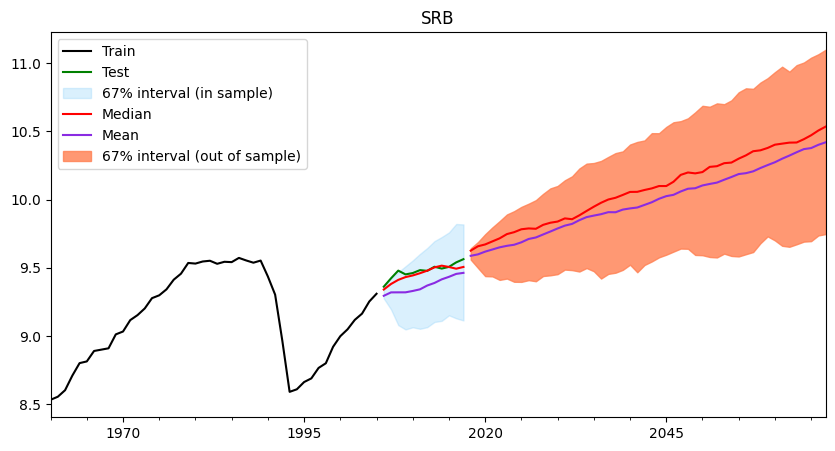

In [ ]:
ind = names.index('SRB')
selected = gdp_data[ind]
train_split = 0.8
lower_quant = 17
upper_quant = 84
horizon = 50
pred_int_perc = 67

data_train, data_test, test_preds, horizon_preds = UnivariateForecasts.univariate_forecast(
    selected,
    arima_orders[ind],
    train_split,
    start_year,
    horizon,
    lower_quant,
    upper_quant,
    True
)

VisualUtils.plot_forecast_intervals(
    data_train,
    data_test,
    names[ind],
    test_preds,
    horizon_preds,
    pred_int_perc
)

## Independent Multi-Series Forecasting

This section includes simultaneous probabilistic recursive predictions for multiple time series, without considering cross-series dependencies. Modelling multiple time series together adds to the robustness of the model, epsecially under the lack of data for the specific experiment. First, we train a single model on the entire dataset of all the countries. Afterwards, we make predictions for individual clusters calculated from Kernel $13$-Means with a Global Alignment Kernel. For this experiment, the cluster containing Iraq, Russia, Serbia and Venezuela is examined. 

### Predictions on the Entire Dataset

In [ ]:
cluster_ind = 4
cluster = [name for i, name in enumerate(names) if labels[i] == cluster_ind]

In [ ]:
train_split = 0.8
lower_quant = 17
upper_quant = 84
horizon = 50
pred_int_perc = 67

data_train, data_test, test_preds, horizon_preds = MultivariateForecasts.multiseries_independent_forecasts(
    y = gdp_data,
    countries = names,
    arima_orders=arima_orders,
    train_split=train_split,
    start_year=start_year,
    horizon=horizon,
    lower_quantile=lower_quant,
    upper_quantile=upper_quant
)


for country in cluster:
    selected_test_preds = DataUtils.select_predictions(country, test_preds)
    selected_horizon_preds = DataUtils.select_predictions(country, horizon_preds)

    VisualUtils.plot_forecast_intervals(
        data_train[country],
        data_test[country],
        country,
        selected_test_preds,
        selected_horizon_preds, 
        67
    )

### Predictions on clusters

In [ ]:
cluster_data = gdp_data[labels==cluster_ind]
orders_cluster = arima_orders[labels==cluster_ind]

data_train, data_test, test_preds, horizon_preds = MultivariateForecasts.multiseries_independent_forecasts(
    y = cluster_data,
    countries = cluster,
    arima_orders=orders_cluster,
    train_split=train_split,
    start_year=start_year,
    horizon=horizon,
    lower_quantile=lower_quant,
    upper_quantile=upper_quant
)


for country in cluster:
    selected_test_preds = DataUtils.select_predictions(country, test_preds)
    selected_horizon_preds = DataUtils.select_predictions(country, horizon_preds)

    VisualUtils.plot_forecast_intervals(
        data_train[country],
        data_test[country],
        country,
        selected_test_preds,
        selected_horizon_preds, 
        67
    )

## Multivariate Time Series Forecasting: Many-to-one

In the following experiments, the past values of all the time series in the dataset are assumed to affect the future values of each individual series. Due to effeciency limitations, the framework implemented by `skforecast` allows to only perform future values of a single time series. The code in this section bypasses the problem by creating a different model for each variable of interest. The same cluster as in the previous section is used for illustration.

### Predictions on the Entire Dataset

In [ ]:
train_split = 0.8
lower_quant = 17
upper_quant = 84
horizon = 50
pred_int_perc = 67

data_train, data_test, test_preds, horizon_preds = MultivariateForecasts.many_to_one_forecasts(
    y = gdp_data,
    countries = names,
    arima_orders=arima_orders,
    train_split=train_split,
    start_year=start_year,
    horizon=horizon,
    lower_quantile=lower_quant,
    upper_quantile=upper_quant,
    countries_to_predict=cluster
)

for country in cluster:
    selected_test_preds = DataUtils.select_predictions(country, test_preds)
    selected_horizon_preds = DataUtils.select_predictions(country, horizon_preds)

    VisualUtils.plot_forecast_intervals(
        data_train[country],
        data_test[country],
        country,
        selected_test_preds,
        selected_horizon_preds, 
        67
    )

### Predictions on clusters

In [ ]:
data_train, data_test, test_preds, horizon_preds = MultivariateForecasts.many_to_one_forecasts(
    y = cluster_data,
    countries = cluster,
    arima_orders=orders_cluster,
    train_split=train_split,
    start_year=start_year,
    horizon=horizon,
    lower_quantile=lower_quant,
    upper_quantile=upper_quant
)

for country in cluster:
    selected_test_preds = DataUtils.select_predictions(country, test_preds)
    selected_horizon_preds = DataUtils.select_predictions(country, horizon_preds)

    VisualUtils.plot_forecast_intervals(
        data_train[country],
        data_test[country],
        country,
        selected_test_preds,
        selected_horizon_preds, 
        67
    )

## Multivariate Time Series Forecasting: Many-to-many

In the following experiments, the past values of all the time series in the dataset are assumed to affect the future values of each individual series and an adjusted version of the previous model is used to perform predictions for multiple series at the same time.

### Predictions on the Entire Dataset

In [ ]:
train_split = 0.8
lower_quant = 17
upper_quant = 84
horizon = 50
pred_int_perc = 67

data_train, data_test, test_preds, horizon_preds = MultivariateForecasts.many_to_many_forecasts(
    y = gdp_data,
    countries = names,
    arima_orders=arima_orders,
    train_split=train_split,
    start_year=start_year,
    horizon=horizon,
    lower_quantile=lower_quant,
    upper_quantile=upper_quant,
    countries_to_predict=cluster
)

for country in cluster:
    selected_test_preds = DataUtils.select_predictions(country, test_preds)
    selected_horizon_preds = DataUtils.select_predictions(country, horizon_preds)

    VisualUtils.plot_forecast_intervals(
        data_train[country],
        data_test[country],
        country,
        selected_test_preds,
        selected_horizon_preds, 
        67
    )

### Predictions on clusters

In [ ]:
data_train, data_test, test_preds, horizon_preds = MultivariateForecasts.many_to_many_forecasts(
    y = cluster_data,
    countries = cluster,
    arima_orders=orders_cluster,
    train_split=train_split,
    start_year=start_year,
    horizon=horizon,
    lower_quantile=lower_quant,
    upper_quantile=upper_quant
)

for country in cluster:
    selected_test_preds = DataUtils.select_predictions(country, test_preds)
    selected_horizon_preds = DataUtils.select_predictions(country, horizon_preds)

    VisualUtils.plot_forecast_intervals(
        data_train[country],
        data_test[country],
        country,
        selected_test_preds,
        selected_horizon_preds, 
        67
    )

## Multivariate Time Series Forecasting: Recurrent Neural Networks

Recurrent neural networks can also be used to produce probabilistic forecasting. The functionality offered by `skforecast` for utilizing RNNs for time series forecasting has been augmented to support prediction bootstrapping.

### Predictions on the Entire Dataset

In [ ]:
train_split = 0.8
lower_quant = 17
upper_quant = 84
horizon = 50
pred_int_perc = 67
layer = 'LSTM'
recurrent_units = 4
dense_units = 16

data_train, data_test, test_preds, horizon_preds = MultivariateForecasts.rnn_forecasts(
    y = gdp_data,
    countries = names,
    arima_orders=arima_orders,
    layer_type=layer,
    recurrent_units=recurrent_units,
    dense_units=dense_units,
    train_split=train_split,
    start_year=start_year,
    horizon=horizon,
    lower_quantile=lower_quant,
    upper_quantile=upper_quant,
    countries_to_predict=cluster
)

for country in cluster:
    selected_test_preds = DataUtils.select_predictions(country, test_preds)
    selected_horizon_preds = DataUtils.select_predictions(country, horizon_preds)

    VisualUtils.plot_forecast_intervals(
        data_train[country],
        data_test[country],
        country,
        selected_test_preds,
        selected_horizon_preds, 
        67
    )

### Predictions on clusters

In [ ]:
data_train, data_test, test_preds, horizon_preds = MultivariateForecasts.rnn_forecasts(
    y = cluster_data,
    countries = cluster,
    arima_orders=arima_orders,
    layer_type=layer,
    recurrent_units=recurrent_units,
    dense_units=dense_units,
    train_split=train_split,
    start_year=start_year,
    horizon=horizon,
    lower_quantile=lower_quant,
    upper_quantile=upper_quant,
)

for country in cluster:
    selected_test_preds = DataUtils.select_predictions(country, test_preds)
    selected_horizon_preds = DataUtils.select_predictions(country, horizon_preds)

    VisualUtils.plot_forecast_intervals(
        data_train[country],
        data_test[country],
        country,
        selected_test_preds,
        selected_horizon_preds, 
        67
    )